# Reconstructing the tropical Pacific SST with PAGES2k

In [1]:
%load_ext autoreload
%autoreload 2

import cfr

In [2]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')

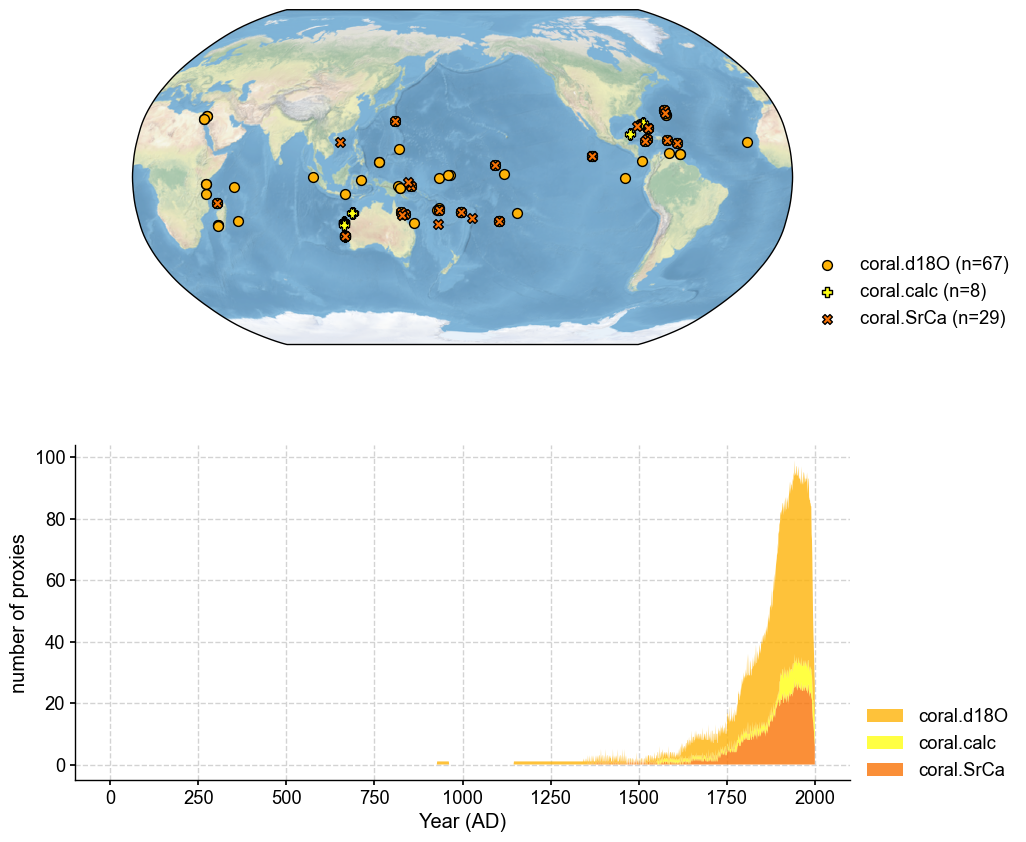

In [3]:
job.filter_proxydb(by='ptype', keys=['coral'])
fig, ax = job.proxydb.plot(plot_count=True)

In [4]:
job.annualize_proxydb(months=[12, 1, 2], ptypes=['coral'], verbose=True)

>>> job.configs["annualize_proxydb_months"] = [12, 1, 2]
>>> job.configs["annualize_proxydb_ptypes"] = ['coral']


Annualizing ProxyDatabase: 100%|██████████| 104/104 [00:02<00:00, 42.18it/s]

>>> 99 records remaining
>>> job.proxydb updated


In [5]:
job.center_proxydb(verbose=True)

>>> job.configs["proxydb_center_ref_period"] = [1951, 1980]


Centering each of the ProxyRecord: 100%|██████████| 99/99 [00:00<00:00, 1290.35it/s]

>>> job.proxydb updated


In [6]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': 'gistemp1200_GHCNv4_ERSSTv5',
    },
    rename_dict={'tas': 'tempanomaly'},
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': 'gistemp1200_GHCNv4_ERSSTv5'}
>>> job.configs["obs_rename_dict"] = {'tas': 'tempanomaly'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> The target file seems existed at: ./data/gistemp1200_GHCNv4_ERSSTv5.nc.gz . Loading from it instead of downloading ...
>>> obs variables ['tas'] loaded
>>> job.obs created


>>> job.configs["obs_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.obs updated
>>> job.configs["obs_regrid_nlat"] = 42
>>> job.configs["obs_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["obs_lat_min"] = -20
>>> job.configs["obs_lat_max"] = 20
>>> job.configs["obs_lon_min"] = 150
>>> job.configs["obs_lon_max"] = 260
>>> Processing tas ...


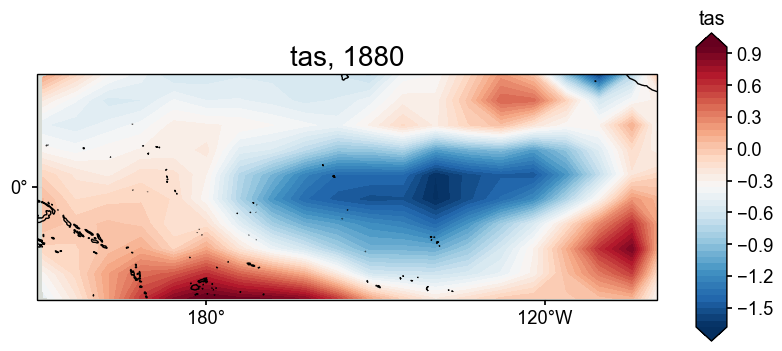

In [7]:
job.annualize_clim(tag='obs', months=[12, 1, 2], verbose=True)
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)
job.crop_clim(tag='obs', lat_min=-20, lat_max=20, lon_min=150, lon_max=260, verbose=True)

fig, ax = job.obs['tas'][0].plot(
    projection='PlateCarree',
    latlon_range=(-20, 20, 150, 260),
)

In [8]:
job.prep_graphem(
    recon_period=(1871, 2000),  # period to reconstruct
    calib_period=(1901, 2000),  # period for calibration
    verbose=True,
)

>>> job.configs["recon_period"] = [1871, 2000]
>>> job.configs["recon_timescale"] = 1
>>> job.configs["calib_period"] = [1901, 2000]
>>> job.graphem_params["recon_time"] created
>>> job.graphem_params["calib_time"] created
>>> job.graphem_params["field_obs"] created
>>> job.graphem_params["calib_idx"] created
>>> job.graphem_params["field"] created
>>> job.graphem_params["df_proxy"] created
>>> job.graphem_params["proxy"] created
>>> job.graphem_params["lonlat"] created


In [9]:
%%time

job.run_graphem(
    save_dirpath='./recons/graphem-real-pages2k',
    graph_method='neighborhood',
    cutoff_radius=1500,
    verbose=True,
)

>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["save_dirpath"] = ./recons/graphem-real-pages2k
>>> job.configs["save_filename"] = job_r01_recon.nc
>>> job.configs["graph_method"] = neighborhood
>>> job.configs["cutoff_radius"] = 1500
Computing a neighborhood graph with R = 1500.0 km
Estimating graph using neighborhood method
Running GraphEM:



EM | dXmis: 0.1391; rdXmis: 0.2755:   2%|▏         | 3/200 [01:46<1:56:56, 35.62s/it]


KeyboardInterrupt: 

In [ ]:
res = cfr.ReconRes('./recons/graphem-real-pages2k')
res.load(['nino3.4', 'tas'], verbose=True)

In [ ]:
target = cfr.ClimateField().fetch('20CRv3/tas', vn='air').rename('tas').get_anom((1951, 1980)).annualize(months=[12, 1, 2])

In [ ]:
res.recons['tas'].da

In [ ]:
# validate the reconstruction against 20CR
stat = 'corr'

valid_fd = res.recons['tas'].compare(
    target, stat=stat, 
    timespan=(1874, 1900),
)
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-20, 20, 150, 260),
    plot_cbar=True,
    plot_proxydb=True, proxydb=job.proxydb,
    proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
)

cfr.showfig(fig)
cfr.savefig(fig, f'./figs/graphem_{stat}_recon_obs.pdf')

In [ ]:
bc09 = cfr.EnsTS().fetch('BC09_NINO34')
bc09_ann = bc09.annualize(months=[12, 1, 2])

In [ ]:
fig, ax = res.recons['nino3.4'].compare(bc09_ann, timespan=(1874, 1900)).plot_qs()
ax.set_xlim(1850, 1900)
ax.set_ylim(-3, 4)
ax.set_ylabel('NINO3.4 [K]')
cfr.showfig(fig)
cfr.savefig(fig, f'./figs/graphem_corr_recon_BC09.pdf')

In [ ]:
inst = job.graphem_params['calib_idx']
G_L = cfr.graphem.Graph(
    lonlat = job.graphem_params['lonlat'],
    field = job.graphem_solver.field_r[inst],
    proxy = job.graphem_params['proxy'][inst,:])

G_L.glasso_adj(target_FF=3,target_FP=4)

In [ ]:
job.graphem_params['proxy'][inst, :].shape

In [ ]:
job.graphem_params['lonlat'].shape